### Selecting columns, viualizing

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [2]:
data = pd.read_csv("../dat/data_clean_new.csv")

C:\Users\Balint\miniconda3\envs\d2l\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273543 entries, 0 to 273542
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       273543 non-null  object 
 1   titleType                    273543 non-null  object 
 2   primaryTitle                 273543 non-null  object 
 3   originalTitle                273543 non-null  object 
 4   isAdult                      273543 non-null  int64  
 5   startYear                    273543 non-null  object 
 6   endYear                      273543 non-null  object 
 7   runtimeMinutes               273543 non-null  object 
 8   genres                       273543 non-null  object 
 9   averageRating                273543 non-null  float64
 10  numVotes                     273543 non-null  int64  
 11  Budget                       49881 non-null   float64
 12  Gross US & Canada            18982 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on

# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
data = data.drop(columns=[
    "tconst", "titleType", "primaryTitle", "originalTitle", "endYear",
    "isAdult", "isAdult2", "Gross US & Canada", "Opening weekend US & Canada",
    "writers", "directors"])
data = data.dropna()

318


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'War', 'Crime', 'Biography', 'Drama', 'Romance', 'Documentary', 'News', 'Horror', 'Adventure', 'Musical', 'Sci-Fi', 'Family', 'Western', 'Animation', 'Film-Noir', 'Fantasy', 'Action', 'Mystery', 'Music', 'Comedy', 'Sport', 'Thriller', 'History'}


In [6]:
# News - History - Biography - Documentary --> Documentary
# Film-Noir - Crime --> Crime
# Western - Action --> Action
genre_set.difference_update(["News", "History", "Biography", "Film-Noir", "Western"])
transformation_dict = {
    "Documentary":  ["News", "History", "Biography", "Documentary"],
    "Crime": ["Film-Noir", "Crime"],
    "Action": ["Western", "Action"]
}
for genre in genre_set:
    print(genre, end=" ")
    if genre not in transformation_dict:
        transformation_dict[genre] = [genre]
    data[f"is{genre}"] = data.apply(lambda row: int(any(g in row["genres"] for g in transformation_dict[genre])), axis=1)

War Crime Drama Romance Documentary Horror Adventure Musical Sci-Fi Family Animation Fantasy Action Mystery Music Comedy Sport Thriller 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "% - ", data[f"is{genre}"].sum())

War 0.8658995100831719 % -  228
Crime 7.569025103490183 % -  1993
Drama 21.920929702631877 % -  5772
Romance 6.737305837226083 % -  1774
Documentary 4.564961452280582 % -  1202
Horror 4.348486574759789 % -  1145
Adventure 6.7107212031445815 % -  1767
Musical 0.5089058524173028 % -  134
Sci-Fi 2.529338042611371 % -  666
Family 2.2938741407466483 % -  604
Animation 1.993847556112567 % -  525
Fantasy 2.8179712126390943 % -  742
Action 9.843910219892901 % -  2592
Mystery 3.4901826744141884 % -  919
Music 1.7659792639854164 % -  465
Comedy 14.488625574417988 % -  3815
Sport 0.9190687782461737 % -  242
Thriller 6.63096730090008 % -  1746


In [8]:
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        # print(row[column], end=" -> ")
        if "." in row[column]:
            # print(int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100)
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            # print(int(row[column][:-1]) * 1000)
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

# Just an example of problematic data types
# print("Problematic form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])

# print("Resolved form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

In [12]:
print("All features present:")
filtered = data.dropna()  # data.dropna()
print(len(filtered))
print()

All features present:
10714



In [13]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isWar,isCrime,isDrama,isRomance,isDocumentary,isHorror,isAdventure,isMusical,isSci-Fi,isFamily,isAnimation,isFantasy,isAction,isMystery,isMusic,isComedy,isSport,isThriller,isRated
startYear,1.000000,-0.035866,-0.201522,0.000240,-0.023247,-0.057779,0.193535,0.059286,-0.055095,-0.043072,-0.023440,-0.072984,0.076020,0.010315,0.014030,-0.079189,-0.021172,-0.006475,0.061377,-0.007435,0.062450,-0.012530,-0.049175,-0.029636,-0.001944,0.037106,-0.166430
runtimeMinutes,-0.035866,1.000000,0.327356,0.263119,0.281783,0.222601,0.197618,0.263035,0.098452,0.034734,0.251510,0.037874,0.132065,-0.161497,0.023855,0.066672,0.013944,-0.076188,-0.188850,-0.007126,0.157000,-0.004244,0.042845,-0.198908,0.023717,-0.017890,-0.059407
averageRating,-0.201522,0.327356,1.000000,0.373765,0.094344,0.207771,0.320645,0.259345,0.073410,0.033494,0.259717,0.017810,0.203175,-0.194478,-0.027122,0.017918,-0.039149,-0.063889,0.016830,-0.050636,-0.088066,-0.005072,0.039827,-0.116203,0.030757,-0.086492,0.009748
numVotes,0.000240,0.263119,0.373765,1.000000,0.484440,0.604826,0.632424,0.748153,-0.003589,0.012083,-0.053881,-0.062362,-0.039296,-0.030451,0.174233,-0.020421,0.161098,-0.019788,0.032153,0.057248,0.143913,0.026221,-0.039960,-0.058298,-0.020418,0.008170,0.181424
Budget,-0.023247,0.281783,0.094344,0.484440,1.000000,0.618972,0.470934,0.493993,-0.018468,-0.030025,-0.180196,-0.074949,-0.066076,-0.114956,0.412964,-0.002538,0.187617,0.073103,0.156256,0.122698,0.288313,-0.035106,-0.046011,0.001382,-0.014845,-0.024849,0.265037
Gross worldwide,-0.057779,0.222601,0.207771,0.604826,0.618972,1.000000,0.447165,0.528583,-0.022194,-0.057878,-0.143340,-0.046415,-0.054449,-0.056392,0.302571,-0.004438,0.120041,0.059786,0.150514,0.085165,0.157823,-0.029502,-0.024488,0.004148,-0.023446,-0.022244,0.165175
Critic reviews,0.193535,0.197618,0.320645,0.632424,0.470934,0.447165,1.000000,0.635358,-0.024894,-0.004029,-0.038121,-0.080864,-0.017815,0.107734,0.174983,-0.023878,0.187049,-0.051485,0.020177,0.089842,0.153225,0.084005,-0.044073,-0.093213,-0.043205,0.045821,0.252920
User reviews,0.059286,0.263035,0.259345,0.748153,0.493993,0.528583,0.635358,1.000000,-0.005661,-0.015094,-0.054181,-0.071699,-0.051012,0.052397,0.178414,-0.001391,0.187933,-0.031068,-0.015183,0.084869,0.168931,0.054678,-0.027985,-0.102268,-0.031435,0.029438,0.181563
isWar,-0.055095,0.098452,0.073410,-0.003589,-0.018468,-0.022194,-0.024894,-0.005661,1.000000,-0.067167,0.093656,-0.004788,0.058241,-0.051007,-0.044618,-0.010775,-0.035284,-0.036042,-0.030476,-0.037676,-0.021383,-0.040548,-0.021886,-0.079938,-0.018063,-0.054507,-0.002274
isCrime,-0.043072,0.034734,0.033494,0.012083,-0.030025,-0.057878,-0.004029,-0.015094,-0.067167,1.000000,0.032473,-0.156808,-0.074934,-0.106358,-0.159447,-0.030058,-0.099232,-0.106446,-0.101847,-0.113395,0.158979,0.084841,-0.066510,-0.096008,-0.066214,0.119284,0.037166


In [14]:
test_indices = np.random.choice(len(filtered), replace=False, size=int(len(filtered) / 10))
test_set = filtered.iloc[test_indices]
test_set, test_targets = test_set.drop("averageRating", axis=1).to_numpy(), test_set["averageRating"].to_numpy()
train_set = filtered.iloc[~test_indices]
train_set, train_targets = train_set.drop("averageRating", axis=1).to_numpy(), train_set["averageRating"].to_numpy()

In [15]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10714 entries, 1031 to 273540
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startYear        10714 non-null  int64  
 1   runtimeMinutes   10714 non-null  float64
 2   averageRating    10714 non-null  float64
 3   numVotes         10714 non-null  int64  
 4   Budget           10714 non-null  float64
 5   Gross worldwide  10714 non-null  float64
 6   Critic reviews   10714 non-null  float64
 7   User reviews     10714 non-null  float64
 8   isWar            10714 non-null  int64  
 9   isCrime          10714 non-null  int64  
 10  isDrama          10714 non-null  int64  
 11  isRomance        10714 non-null  int64  
 12  isDocumentary    10714 non-null  int64  
 13  isHorror         10714 non-null  int64  
 14  isAdventure      10714 non-null  int64  
 15  isMusical        10714 non-null  int64  
 16  isSci-Fi         10714 non-null  int64  
 17  isFamily

In [16]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression().fit(train_set, train_targets)
# print(lr.predict(train_set) * 9 + 1)
# print(train_targets * 9 + 1)
# # print(lr.score(test_set, test_targets))

### Logistic Regression, MAE

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

test_set = torch.from_numpy(test_set)
test_set_normalized = (test_set - test_set.mean(dim=0, keepdims=True)) / test_set.std(dim=0, keepdims=True)
test_set_normalized = torch.nan_to_num(test_set_normalized, nan=0)
test_targets = torch.from_numpy(test_targets)

train_set = torch.from_numpy(train_set)
train_set_normalized = (train_set - train_set.mean(dim=0, keepdims=True)) / train_set.std(dim=0, keepdims=True)
train_set_normalized = torch.nan_to_num(train_set_normalized, nan=0)
train_targets = torch.from_numpy(train_targets)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x)) * 9 + 1

In [22]:
# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

tensor([0.0763], dtype=torch.float64)
Epoch 100, Training Loss (MAE) 1.1235, Validation Loss (MAE) 1.1726

tensor([0.0579], dtype=torch.float64)
Epoch 200, Training Loss (MAE) 0.9413, Validation Loss (MAE) 0.9956

tensor([0.0424], dtype=torch.float64)
Epoch 300, Training Loss (MAE) 0.8056, Validation Loss (MAE) 0.8635

tensor([0.0290], dtype=torch.float64)
Epoch 400, Training Loss (MAE) 0.7090, Validation Loss (MAE) 0.7730

tensor([0.0172], dtype=torch.float64)
Epoch 500, Training Loss (MAE) 0.6506, Validation Loss (MAE) 0.7157

tensor([0.0086], dtype=torch.float64)
Epoch 600, Training Loss (MAE) 0.6172, Validation Loss (MAE) 0.6824

tensor([0.0053], dtype=torch.float64)
Epoch 700, Training Loss (MAE) 0.5999, Validation Loss (MAE) 0.6647

tensor([0.0022], dtype=torch.float64)
Epoch 800, Training Loss (MAE) 0.5908, Validation Loss (MAE) 0.6547

tensor([0.0012], dtype=torch.float64)
Epoch 900, Training Loss (MAE) 0.5863, Validation Loss (MAE) 0.6485

tensor([0.0009], dtype=torch.float64)

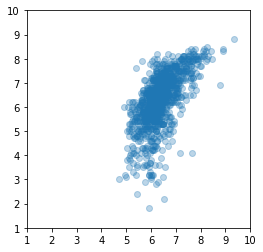

In [23]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Logistic Regression, MSE

In [24]:
loss_fn = nn.MSELoss()
val_loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MSE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

tensor([0.2696], dtype=torch.float64)
Epoch 100, Training Loss (MSE) 1.0308, Validation Loss (MAE) 0.9032

tensor([0.0460], dtype=torch.float64)
Epoch 200, Training Loss (MSE) 0.7027, Validation Loss (MAE) 0.7228

tensor([0.0107], dtype=torch.float64)
Epoch 300, Training Loss (MSE) 0.6394, Validation Loss (MAE) 0.6709

tensor([0.0032], dtype=torch.float64)
Epoch 400, Training Loss (MSE) 0.6229, Validation Loss (MAE) 0.6519

tensor([0.0012], dtype=torch.float64)
Epoch 500, Training Loss (MSE) 0.6175, Validation Loss (MAE) 0.6436

tensor([0.0006], dtype=torch.float64)
Epoch 600, Training Loss (MSE) 0.6152, Validation Loss (MAE) 0.6396

tensor([0.0003], dtype=torch.float64)
Epoch 700, Training Loss (MSE) 0.6141, Validation Loss (MAE) 0.6375

tensor([0.0002], dtype=torch.float64)
Epoch 800, Training Loss (MSE) 0.6134, Validation Loss (MAE) 0.6363

tensor([0.0001], dtype=torch.float64)
Epoch 900, Training Loss (MSE) 0.6130, Validation Loss (MAE) 0.6355

Final Validation Loss (MAE) 0.6352


### Logistic Regression, BCE

In [28]:
test_targets_bce = (test_targets - 1) / 9
train_targets_bce = (train_targets - 1) / 9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

loss_fn = nn.BCELoss()
val_loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets_bce)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (BCE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

tensor([0.0010], dtype=torch.float64)
Epoch 100, Training Loss (BCE) 0.7093, Validation Loss (MAE) 1.1302

tensor([0.0010], dtype=torch.float64)
Epoch 200, Training Loss (BCE) 0.7066, Validation Loss (MAE) 1.1077

tensor([0.0009], dtype=torch.float64)
Epoch 300, Training Loss (BCE) 0.7041, Validation Loss (MAE) 1.0864

tensor([0.0008], dtype=torch.float64)
Epoch 400, Training Loss (BCE) 0.7019, Validation Loss (MAE) 1.0662

tensor([0.0007], dtype=torch.float64)
Epoch 500, Training Loss (BCE) 0.6998, Validation Loss (MAE) 1.0474

tensor([0.0007], dtype=torch.float64)
Epoch 600, Training Loss (BCE) 0.6979, Validation Loss (MAE) 1.0298

tensor([0.0006], dtype=torch.float64)
Epoch 700, Training Loss (BCE) 0.6961, Validation Loss (MAE) 1.0136

tensor([0.0006], dtype=torch.float64)
Epoch 800, Training Loss (BCE) 0.6944, Validation Loss (MAE) 0.9981

tensor([0.0005], dtype=torch.float64)
Epoch 900, Training Loss (BCE) 0.6929, Validation Loss (MAE) 0.9833

tensor([0.0005], dtype=torch.float64)

### ReLU network #2, MAE

In [31]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

model = Model()
list(model.modules())[1:]

[Linear(in_features=26, out_features=32, bias=True),
 Linear(in_features=32, out_features=1, bias=True)]

In [49]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])

# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

Epoch 100, Training Loss (MAE) 0.7472, Validation Loss (MAE) 0.8007

Epoch 200, Training Loss (MAE) 0.6876, Validation Loss (MAE) 0.7468

Epoch 300, Training Loss (MAE) 0.6488, Validation Loss (MAE) 0.7159

Epoch 400, Training Loss (MAE) 0.6244, Validation Loss (MAE) 0.6939

Epoch 500, Training Loss (MAE) 0.6057, Validation Loss (MAE) 0.6766

Epoch 600, Training Loss (MAE) 0.5916, Validation Loss (MAE) 0.6626

Epoch 700, Training Loss (MAE) 0.5802, Validation Loss (MAE) 0.6523

Epoch 800, Training Loss (MAE) 0.5704, Validation Loss (MAE) 0.6426

Epoch 900, Training Loss (MAE) 0.5622, Validation Loss (MAE) 0.6346

Epoch 1000, Training Loss (MAE) 0.5550, Validation Loss (MAE) 0.6286

Epoch 1100, Training Loss (MAE) 0.5488, Validation Loss (MAE) 0.6229

Epoch 1200, Training Loss (MAE) 0.5433, Validation Loss (MAE) 0.6173

Epoch 1300, Training Loss (MAE) 0.5386, Validation Loss (MAE) 0.6124

Epoch 1400, Training Loss (MAE) 0.5346, Validation Loss (MAE) 0.6083

Epoch 1500, Training Loss (MA

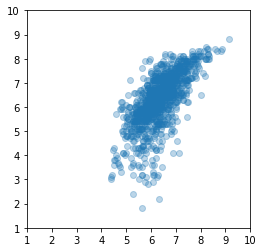

In [50]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### ReLU network #4, MAE

In [51]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 32, dtype=torch.double)
        self.layer3 = nn.Linear(32, 32, dtype=torch.double)
        self.layer4 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
    
        return torch.sigmoid(self.layer4(x)) * 9 + 1

loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])

# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

Epoch 100, Training Loss (MAE) 0.8221, Validation Loss (MAE) 0.8722

Epoch 200, Training Loss (MAE) 0.7987, Validation Loss (MAE) 0.8521

Epoch 300, Training Loss (MAE) 0.7923, Validation Loss (MAE) 0.8468

Epoch 400, Training Loss (MAE) 0.7862, Validation Loss (MAE) 0.8418

Epoch 500, Training Loss (MAE) 0.7796, Validation Loss (MAE) 0.8363

Epoch 600, Training Loss (MAE) 0.7721, Validation Loss (MAE) 0.8302

Epoch 700, Training Loss (MAE) 0.7639, Validation Loss (MAE) 0.8233

Epoch 800, Training Loss (MAE) 0.7541, Validation Loss (MAE) 0.8154

Epoch 900, Training Loss (MAE) 0.7428, Validation Loss (MAE) 0.8066

Epoch 1000, Training Loss (MAE) 0.7305, Validation Loss (MAE) 0.7968

Epoch 1100, Training Loss (MAE) 0.7169, Validation Loss (MAE) 0.7855

Epoch 1200, Training Loss (MAE) 0.7048, Validation Loss (MAE) 0.7745

Epoch 1300, Training Loss (MAE) 0.6941, Validation Loss (MAE) 0.7636

Epoch 1400, Training Loss (MAE) 0.6838, Validation Loss (MAE) 0.7527

Epoch 1500, Training Loss (MA

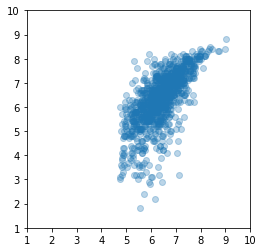

In [52]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

In [54]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 32, dtype=torch.double)
        self.layer3 = nn.Linear(32, 32, dtype=torch.double)
        self.layer4 = nn.Linear(32, 32, dtype=torch.double)
        self.layer5 = nn.Linear(32, 32, dtype=torch.double)
        self.layer6 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
    
        return torch.sigmoid(self.layer6(x)) * 9 + 1

loss_fn = nn.L1Loss()

model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])

# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")

Epoch 100, Training Loss (MAE) 0.8061, Validation Loss (MAE) 0.8571

Epoch 200, Training Loss (MAE) 0.8054, Validation Loss (MAE) 0.8564

Epoch 300, Training Loss (MAE) 0.8048, Validation Loss (MAE) 0.8559

Epoch 400, Training Loss (MAE) 0.8043, Validation Loss (MAE) 0.8554

Epoch 500, Training Loss (MAE) 0.8037, Validation Loss (MAE) 0.8549

Epoch 600, Training Loss (MAE) 0.8031, Validation Loss (MAE) 0.8543

Epoch 700, Training Loss (MAE) 0.8024, Validation Loss (MAE) 0.8537

Epoch 800, Training Loss (MAE) 0.8016, Validation Loss (MAE) 0.8529

Epoch 900, Training Loss (MAE) 0.8006, Validation Loss (MAE) 0.8520

Epoch 1000, Training Loss (MAE) 0.7993, Validation Loss (MAE) 0.8507

Epoch 1100, Training Loss (MAE) 0.7974, Validation Loss (MAE) 0.8490

Epoch 1200, Training Loss (MAE) 0.7947, Validation Loss (MAE) 0.8465

Epoch 1300, Training Loss (MAE) 0.7904, Validation Loss (MAE) 0.8425

Epoch 1400, Training Loss (MAE) 0.7832, Validation Loss (MAE) 0.8358

Epoch 1500, Training Loss (MA

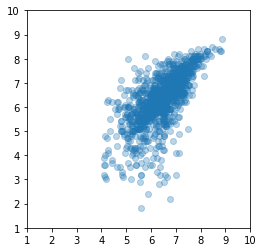

In [55]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Linear Regression, Transformed Outputs

In [56]:
filtered[filtered["averageRating"] <= 1.3]  # we can use inverse formula

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isWar,isCrime,...,isFamily,isAnimation,isFantasy,isAction,isMystery,isMusic,isComedy,isSport,isThriller,isRated


In [61]:
test_targets_inv = -torch.log(9 / (test_targets - 1) - 1)
train_targets_inv = -torch.log(9 / (train_targets - 1) - 1)

In [62]:
train_targets_inv.min(), train_targets_inv.max()

(tensor(-1.6094, dtype=torch.float64), tensor(1.8718, dtype=torch.float64))

In [63]:
max(train_targets)
train_set.shape

torch.Size([1071, 26])

In [64]:
opt_weights = torch.linalg.pinv(train_set) @ train_targets_inv

transformed_preds = test_set @ opt_weights
preds = 9 * 1 / (1 + torch.exp(-transformed_preds)) + 1
((test_targets - preds)**2).mean()

tensor(0.8216, dtype=torch.float64)